<a href="https://colab.research.google.com/github/MMoronto/peutingar-labs/blob/master/Peutingar_datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Data Dictionary

In [1]:
pip install pytorch-forecasting

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.5/88.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 55.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.1/57.1 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.9/66.9 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.8/57.8 kB 4.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 553.5/553.5 kB 22.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━

##Load data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

path1='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls'
path2='/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.csv'
fob=open(path2,)
headings=next(fob)
for rec in fob:
  Cement3=rec.split(',')
  print(Cement3)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['"SALIENT CEMENT STATISTICS1', ' 2 "', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['(Thousand metric tons unless otherwise specified)', '', '', '', '', '', '', '\n']
['', '', '', '', '', '', '', '\n']
['', '', '', '2014', '2015', '2016', '2017', '2018\n']
['United States:', '', '', '', '', '', '', '\n']
['Production:', '', '', '', '', '', '', '\n']
['Cement3', '', '', '"82', '535"', '"84', '405"', '"84', '695"', '"86', '356"', '"86', '400"\n']
['Clinker', '', '', '"74', '372"', '"76', '043"', '"75', '633"', '"76', '678"', '"77', '112"\n']
['"Shipments from mills and terminals:3', ' 4"', '', '', '', '', '', '', '\n']
['Quantity', '', '', '"88', '900"', '"92', '000"', '"94', '300"', '"96', '900"', '"98', '500"\n']
['Value5', 'thousand dollars', '', '"8', '940', '000"', '"9', '800', '000"', '"10', '500', '000"', '"11', '300', '000"', '"11'

In [3]:
import os
import warnings

warnings.filterwarnings("ignore")  # avoid printing out absolute paths

os.chdir("../../..")

import copy
from pathlib import Path
import warnings

import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters


In [4]:
# Create a series and let pandas create a default integer index:
s = pd.Series([1, 3, 5, np.nan, 6, 8])
s

0    1.0
1    3.0
2    5.0
3    NaN
4    6.0
5    8.0
dtype: float64

In [5]:
from pandas.io.stata import DatetimeIndex
# Create a DataFrame by passing a NumPy array with a dateline index using `date_range()` & labeled columns:
dates = pd.date_range("20230101", periods=8)

dates

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05', '2023-01-06'], dtype='datetime64[ns]', freq='D')

df = pd.DataFrame(np.random.randn(8, 6), index=dates, columns=list("ABCDEF"))

df 

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [6]:
# Create a `DataFrame` by passing a dictionary of objects that can be converted into a series-like structure:

df2 = pd.DataFrame(
    {
        "A": 1.0,
        "B": pd.Timestamp("20230102"),
        "C": pd.Series(1, index=list(range(4)), dtype="float32"),
        "D": np.array([3] * 4, dtype="int32"),
        "E": pd.Categorical(["test", "train", "test", "train"]),
        "F": "foo",
    }
)

df2

,A,B,C,D,E,F
0,1.0,2023-01-02,1.0,3,test,foo
1,1.0,2023-01-02,1.0,3,train,foo
2,1.0,2023-01-02,1.0,3,test,foo
3,1.0,2023-01-02,1.0,3,train,foo


In [7]:
df2.dtypes

A           float64
B    datetime64[ns]
C           float32
D             int32
E          category
F            object
dtype: object

In [8]:
df2.D

0    3
1    3
2    3
3    3
Name: D, dtype: int32

##Viewing data

In [9]:
df.head()

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678


In [10]:
df.tail()

,A,B,C,D,E,F
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [11]:
df.columns

Index(['A', 'B', 'C', 'D', 'E', 'F'], dtype='object')

In [12]:
df.index

DatetimeIndex(['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04',
               '2023-01-05', '2023-01-06', '2023-01-07', '2023-01-08'],
              dtype='datetime64[ns]', freq='D')

`DataFrame.to_numpy()` gives a NumPy representation of the underlying data. 

In [13]:
df.to_numpy()

array([[-2.07418211, -0.50610816, -0.76526387, -0.6585277 ,  1.72276294,
         1.33762852],
       [ 0.27432417, -0.52115816,  0.16038907,  0.97328811, -0.28731431,
        -0.07026099],
       [-0.74197555, -1.75949551,  0.6416345 , -1.87805846,  0.09893863,
         1.61076863],
       [-1.06053913, -0.62692088, -0.82681452, -0.40017678,  0.77479957,
         1.84734495],
       [-0.35704917, -0.11719542,  0.20760333,  0.77740682, -0.91276374,
        -0.95567788],
       [ 1.18893475,  0.35696643, -0.65545058,  0.4097403 ,  0.589076  ,
        -0.95457538],
       [ 3.38093113, -0.5301506 , -0.48019818,  0.02921098,  0.31046756,
         0.53640404],
       [ 0.62902963,  0.3750873 ,  0.40036673, -0.8773172 , -0.29880475,
        -0.09060459]])

In [14]:
df2.to_numpy()

array([[1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'test', 'foo'],
       [1.0, Timestamp('2023-01-02 00:00:00'), 1.0, 3, 'train', 'foo']],
      dtype=object)

In [15]:
df.describe()

,A,B,C,D,E,F
count,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000
mean,0.154934,-0.416122,-0.164717,-0.203054,0.249645,0.407628
std,1.657371,0.675516,0.579805,0.947262,0.804257,1.107934
min,-2.074182,-1.759496,-0.826815,-1.878058,-0.912764,-0.955678
25%,-0.821616,-0.554343,-0.682904,-0.713225,-0.290187,-0.306597
50%,-0.041363,-0.513633,-0.159905,-0.185483,0.204703,0.233072
75%,0.769006,0.001345,0.255794,0.501657,0.635507,1.405914
max,3.380931,0.375087,0.641634,0.973288,1.722763,1.847345


In [16]:
df

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [17]:
df.T

,2023-01-01,2023-01-02,2023-01-03,2023-01-04,2023-01-05,2023-01-06,2023-01-07,2023-01-08
A,-2.074182,0.274324,-0.741976,-1.060539,-0.357049,1.188935,3.380931,0.629030
B,-0.506108,-0.521158,-1.759496,-0.626921,-0.117195,0.356966,-0.530151,0.375087
C,-0.765264,0.160389,0.641634,-0.826815,0.207603,-0.655451,-0.480198,0.400367
D,-0.658528,0.973288,-1.878058,-0.400177,0.777407,0.409740,0.029211,-0.877317
E,1.722763,-0.287314,0.098939,0.774800,-0.912764,0.589076,0.310468,-0.298805
F,1.337629,-0.070261,1.610769,1.847345,-0.955678,-0.954575,0.536404,-0.090605


In [18]:
df.sort_index(axis=1, ascending=False)

,F,E,D,C,B,A
2023-01-01,1.337629,1.722763,-0.658528,-0.765264,-0.506108,-2.074182
2023-01-02,-0.070261,-0.287314,0.973288,0.160389,-0.521158,0.274324
2023-01-03,1.610769,0.098939,-1.878058,0.641634,-1.759496,-0.741976
2023-01-04,1.847345,0.774800,-0.400177,-0.826815,-0.626921,-1.060539
2023-01-05,-0.955678,-0.912764,0.777407,0.207603,-0.117195,-0.357049
2023-01-06,-0.954575,0.589076,0.409740,-0.655451,0.356966,1.188935
2023-01-07,0.536404,0.310468,0.029211,-0.480198,-0.530151,3.380931
2023-01-08,-0.090605,-0.298805,-0.877317,0.400367,0.375087,0.629030


In [19]:
df.sort_values(by="B")

,A,B,C,D,E,F
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [20]:
df

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


##Getting

In [21]:
# Select a single column, which yields a Series, equivalent to 'df.A'
df["A"]

2023-01-01   -2.074182
2023-01-02    0.274324
2023-01-03   -0.741976
2023-01-04   -1.060539
2023-01-05   -0.357049
2023-01-06    1.188935
2023-01-07    3.380931
2023-01-08    0.629030
Freq: D, Name: A, dtype: float64

Selecting via `[]` `(__getitem__)`, which slices the rows:

In [22]:
df[0:3]

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769


In [23]:
df["20230102":"20230104"]

,A,B,C,D,E,F
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345


In [24]:
df

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


##Selection by label

In [25]:
df.loc[dates[1]]

A    0.274324
B   -0.521158
C    0.160389
D    0.973288
E   -0.287314
F   -0.070261
Name: 2023-01-02 00:00:00, dtype: float64

In [26]:
#Selecting on a multi-axis by label:
df.loc[:, ["A", "D"]]

,A,D
2023-01-01,-2.074182,-0.658528
2023-01-02,0.274324,0.973288
2023-01-03,-0.741976,-1.878058
2023-01-04,-1.060539,-0.400177
2023-01-05,-0.357049,0.777407
2023-01-06,1.188935,0.409740
2023-01-07,3.380931,0.029211
2023-01-08,0.629030,-0.877317


In [27]:
# Showing label slicing, both endpoints are included:
df.loc["20230104":"20230106", ["A", "D"]]

,A,D
2023-01-04,-1.060539,-0.400177
2023-01-05,-0.357049,0.777407
2023-01-06,1.188935,0.409740


In [28]:
# Reduction in the dimensions of the returned object:
df.loc["20230104", ["A", "D"]]

A   -1.060539
D   -0.400177
Name: 2023-01-04 00:00:00, dtype: float64

In [29]:
# For getting a scalar value
df.loc[dates[1], "D"]

0.9732881093823968

In [30]:
# For getting fast access to a scalar value
df.at[dates[1], "D"]

0.9732881093823968

##Selection by position

In [31]:
df.iloc[3]

A   -1.060539
B   -0.626921
C   -0.826815
D   -0.400177
E    0.774800
F    1.847345
Name: 2023-01-04 00:00:00, dtype: float64

In [32]:
df.iloc[3:5, 0:2]

,A,B
2023-01-04,-1.060539,-0.626921
2023-01-05,-0.357049,-0.117195


In [33]:
df.iloc[[1, 2, 4], [0, 2]]

,A,C
2023-01-02,0.274324,0.160389
2023-01-03,-0.741976,0.641634
2023-01-05,-0.357049,0.207603


In [34]:
# For slicing rows explicitly
df.iloc[1:3, :]

,A,B,C,D,E,F
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769


In [35]:
# For slicing columns explicitly
df.iloc[:, 1:3]

,B,C
2023-01-01,-0.506108,-0.765264
2023-01-02,-0.521158,0.160389
2023-01-03,-1.759496,0.641634
2023-01-04,-0.626921,-0.826815
2023-01-05,-0.117195,0.207603
2023-01-06,0.356966,-0.655451
2023-01-07,-0.530151,-0.480198
2023-01-08,0.375087,0.400367


In [36]:
# For getting values explicitly
df.iloc[1, 1]

-0.5211581628239979

In [37]:
# For getting fast access to scalar (equivalent to the prior method)
df.iat[1, 1]

-0.5211581628239979

## Boolean indexing
Using a single column's values to select data:

In [38]:
df[df["A"] > 0]

,A,B,C,D,E,F
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [39]:
# Selecting values from a DataFrame where a boolean condition is met:
df[df > 0]

,A,B,C,D,E,F
2023-01-01,NaN,NaN,NaN,NaN,1.722763,1.337629
2023-01-02,0.274324,NaN,0.160389,0.973288,NaN,NaN
2023-01-03,NaN,NaN,0.641634,NaN,0.098939,1.610769
2023-01-04,NaN,NaN,NaN,NaN,0.774800,1.847345
2023-01-05,NaN,NaN,0.207603,0.777407,NaN,NaN
2023-01-06,1.188935,0.356966,NaN,0.409740,0.589076,NaN
2023-01-07,3.380931,NaN,NaN,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,NaN,NaN,NaN


In [40]:
df

,A,B,C,D,E,F
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605


In [41]:
# Using the isin() method for filtering:
df2 = df.copy()

df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2

,A,B,C,D,E,F,G
2023-01-01,-2.074182,-0.506108,-0.765264,-0.658528,1.722763,1.337629,one
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261,one
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769,two
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345,three
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678,four
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575,three
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404,five
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605,four


In [42]:
df2["G"] = ["one", "one", "two", "three", "four", "three", "five", "four"]

df2[df2["G"].isin(["two", "four"])]

,A,B,C,D,E,F,G
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769,two
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678,four
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605,four


## Setting

Setting a new column automatically aligns the data by the indexes:

In [43]:
s1 = pd.Series([1, 2, 3, 4, 5, 6], index=pd.date_range("20230102", periods=6))
s1

2023-01-02    1
2023-01-03    2
2023-01-04    3
2023-01-05    4
2023-01-06    5
2023-01-07    6
Freq: D, dtype: int64

In [44]:
df["G"] = s1

In [45]:
# Setting values by label:
df.at[dates[0], "A"] = 0

In [46]:
# Setting values by position:
df.iat[0, 1] = 0

In [47]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,1.722763,1.337629,NaN
2023-01-02,0.274324,-0.521158,0.160389,0.973288,-0.287314,-0.070261,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,0.098939,1.610769,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,0.774800,1.847345,3.0
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,-0.912764,-0.955678,4.0
2023-01-06,1.188935,0.356966,-0.655451,0.409740,0.589076,-0.954575,5.0
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,0.310468,0.536404,6.0
2023-01-08,0.629030,0.375087,0.400367,-0.877317,-0.298805,-0.090605,NaN


In [48]:
# Setting by assigning with a NumPy array:
df.loc[:, "E"] = np.array([5] * len(df))

In [49]:
# The result of the prior setting operations:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,NaN
2023-01-02,0.274324,-0.521158,0.160389,0.973288,5,-0.070261,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,5,1.610769,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,5,1.847345,3.0
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,5,-0.955678,4.0
2023-01-06,1.188935,0.356966,-0.655451,0.409740,5,-0.954575,5.0
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,5,0.536404,6.0
2023-01-08,0.629030,0.375087,0.400367,-0.877317,5,-0.090605,NaN


In [50]:
# A where operation with setting:

df2 = df.copy()

df2[df2 > 0] = -df2

df2

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,-5,-1.337629,NaN
2023-01-02,-0.274324,-0.521158,-0.160389,-0.973288,-5,-0.070261,-1.0
2023-01-03,-0.741976,-1.759496,-0.641634,-1.878058,-5,-1.610769,-2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,-5,-1.847345,-3.0
2023-01-05,-0.357049,-0.117195,-0.207603,-0.777407,-5,-0.955678,-4.0
2023-01-06,-1.188935,-0.356966,-0.655451,-0.409740,-5,-0.954575,-5.0
2023-01-07,-3.380931,-0.530151,-0.480198,-0.029211,-5,-0.536404,-6.0
2023-01-08,-0.629030,-0.375087,-0.400367,-0.877317,-5,-0.090605,NaN


##Missing data
pandas primarily uses the value `np.nan` to represent missing data. It is by default not included in computations.

Reindexing allows you to change/add/delete the index on a specified axis. This returns a copy of the data:

In [51]:
df1 = df.reindex(index=dates[0:4], columns=list(df.columns) + ["G"])

df1.loc[dates[0] : dates[1], "G"] = 1

df1

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,1.0,1.0
2023-01-02,0.274324,-0.521158,0.160389,0.973288,5,-0.070261,1.0,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,5,1.610769,2.0,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,5,1.847345,3.0,3.0


`DataFrame.dropna()` drops any rows that have missing data:

In [52]:
df1.dropna(how="any")

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,1.0,1.0
2023-01-02,0.274324,-0.521158,0.160389,0.973288,5,-0.070261,1.0,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,5,1.610769,2.0,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,5,1.847345,3.0,3.0


`DataFrame.fillna()` fills missing data:

In [53]:
df1.fillna(value=0)

,A,B,C,D,E,F,G,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,1.0,1.0
2023-01-02,0.274324,-0.521158,0.160389,0.973288,5,-0.070261,1.0,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,5,1.610769,2.0,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,5,1.847345,3.0,3.0


`isna()` gets the boolean mask where values are `nan`:

In [54]:
pd.isna(df1)

,A,B,C,D,E,F,G,G
2023-01-01,False,False,False,False,False,False,False,False
2023-01-02,False,False,False,False,False,False,False,False
2023-01-03,False,False,False,False,False,False,False,False
2023-01-04,False,False,False,False,False,False,False,False


##Operations

In [55]:
df

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,NaN
2023-01-02,0.274324,-0.521158,0.160389,0.973288,5,-0.070261,1.0
2023-01-03,-0.741976,-1.759496,0.641634,-1.878058,5,1.610769,2.0
2023-01-04,-1.060539,-0.626921,-0.826815,-0.400177,5,1.847345,3.0
2023-01-05,-0.357049,-0.117195,0.207603,0.777407,5,-0.955678,4.0
2023-01-06,1.188935,0.356966,-0.655451,0.409740,5,-0.954575,5.0
2023-01-07,3.380931,-0.530151,-0.480198,0.029211,5,0.536404,6.0
2023-01-08,0.629030,0.375087,0.400367,-0.877317,5,-0.090605,NaN


In [56]:
df.mean()

A    0.414207
B   -0.352858
C   -0.164717
D   -0.203054
E    5.000000
F    0.407628
G    3.500000
dtype: float64

Operating with objects that have different dimensionality and need alignment.

In [57]:
s = pd.Series([1, 3, 4, 5, np.nan, 6, 7, 8], index=dates).shift(2)
s

2023-01-01    NaN
2023-01-02    NaN
2023-01-03    1.0
2023-01-04    3.0
2023-01-05    4.0
2023-01-06    5.0
2023-01-07    NaN
2023-01-08    6.0
Freq: D, dtype: float64

In [58]:
df.sub(s, axis="index")

,A,B,C,D,E,F,G
2023-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-03,-1.741976,-2.759496,-0.358366,-2.878058,4.0,0.610769,1.0
2023-01-04,-4.060539,-3.626921,-3.826815,-3.400177,2.0,-1.152655,0.0
2023-01-05,-4.357049,-4.117195,-3.792397,-3.222593,1.0,-4.955678,0.0
2023-01-06,-3.811065,-4.643034,-5.655451,-4.590260,0.0,-5.954575,0.0
2023-01-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-01-08,-5.370970,-5.624913,-5.599633,-6.877317,-1.0,-6.090605,NaN


##Apply
`DataFrame.apply()` applies a user defined function to the data

In [59]:
df.apply(np.cumsum)

,A,B,C,D,E,F,G
2023-01-01,0.000000,0.000000,-0.765264,-0.658528,5,1.337629,NaN
2023-01-02,0.274324,-0.521158,-0.604875,0.314760,10,1.267368,1.0
2023-01-03,-0.467651,-2.280654,0.036760,-1.563298,15,2.878136,3.0
2023-01-04,-1.528191,-2.907575,-0.790055,-1.963475,20,4.725481,6.0
2023-01-05,-1.885240,-3.024770,-0.582451,-1.186068,25,3.769803,10.0
2023-01-06,-0.696305,-2.667804,-1.237902,-0.776328,30,2.815228,15.0
2023-01-07,2.684626,-3.197954,-1.718100,-0.747117,35,3.351632,21.0
2023-01-08,3.313656,-2.822867,-1.317734,-1.624434,40,3.261027,NaN


In [60]:
df.apply(lambda x: x.max() - x.min())

A    4.441470
B    2.134583
C    1.468449
D    2.851347
E    0.000000
F    2.803023
G    5.000000
dtype: float64

##Histogramming

In [61]:
s = pd.Series(np.random.randint(0, 7, size=10))
s

0    6
1    2
2    5
3    5
4    6
5    5
6    0
7    2
8    1
9    1
dtype: int64

In [62]:
s.value_counts()

5    3
6    2
2    2
1    2
0    1
dtype: int64

##String Methods


In [63]:
s = pd.Series(["A", "B", "C", "Aaba", "Baca", np.nan, "CABA", "dog", "cat"])
s.str.lower()

0       a
1       b
2       c
3    aaba
4    baca
5     NaN
6    caba
7     dog
8     cat
dtype: object

##Merge

In [64]:
df = pd.DataFrame(np.random.randn(10, 4))
df

,0,1,2,3
0,-1.624983,-0.964877,-1.911066,-0.176186
1,0.054886,0.647352,0.734534,-2.399606
2,3.160028,-0.122371,0.840891,-0.364307
3,1.442258,0.123908,0.289398,-0.091178
4,-1.050310,-0.230399,0.550806,-0.165901
5,1.011581,0.086784,-1.952359,-2.083834
6,0.255562,-0.898757,-0.844970,-0.548329
7,1.095765,-0.266545,1.602903,-0.729650
8,-0.478503,-0.090623,-0.606843,-0.021968
9,-1.323761,-0.122967,0.609115,-0.255157


In [65]:
# break it into pieces
pieces = [df[:3], df[3:7], df[7:]]
pd.concat(pieces)

,0,1,2,3
0,-1.624983,-0.964877,-1.911066,-0.176186
1,0.054886,0.647352,0.734534,-2.399606
2,3.160028,-0.122371,0.840891,-0.364307
3,1.442258,0.123908,0.289398,-0.091178
4,-1.050310,-0.230399,0.550806,-0.165901
5,1.011581,0.086784,-1.952359,-2.083834
6,0.255562,-0.898757,-0.844970,-0.548329
7,1.095765,-0.266545,1.602903,-0.729650
8,-0.478503,-0.090623,-0.606843,-0.021968
9,-1.323761,-0.122967,0.609115,-0.255157


##Join
`merge()` enables SQL style join types along specific columns. See the Database style joining section.

In [66]:
left = pd.DataFrame({"key": ["foo", "foo"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "foo"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,foo,2


In [67]:
right

,key,rval
0,foo,4
1,foo,5


In [68]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,foo,1,5
2,foo,2,4
3,foo,2,5


In [69]:
# Another example that can be given is:
left = pd.DataFrame({"key": ["foo", "bar"], "lval": [1, 2]})
right = pd.DataFrame({"key": ["foo", "bar"], "rval": [4, 5]})
left

,key,lval
0,foo,1
1,bar,2


In [70]:
right

,key,rval
0,foo,4
1,bar,5


In [71]:
pd.merge(left, right, on="key")

,key,lval,rval
0,foo,1,4
1,bar,2,5


##Grouping
By "group by" we are reffering to a process involving one or more of the following steps:


*   **Splitting** the data into groups based on some criteria
*   **Applying** a function to each independently
*   **Combining** the results into a data structure



In [72]:
df = pd.DataFrame(
    {
        "A": ["foo", "bar","foo", "bar","foo", "bar", "foo", "foo"],
        "B": ["one", "one","two", "three","two", "two", "one", "three"],
        "C": np.random.randn(8),
        "D": np.random.randn(8),
    }
)

df

,A,B,C,D
0,foo,one,-0.579005,-0.710086
1,bar,one,0.753058,0.600487
2,foo,two,-1.188555,0.226256
3,bar,three,-0.286476,-1.078054
4,foo,two,0.666140,-2.157921
5,bar,two,-0.964372,-1.195378
6,foo,one,-0.437675,-0.712922
7,foo,three,-0.768764,-1.587561


Grouping and then applying the `sum()` function to the resulting groups:

In [73]:
df.groupby("A")[["C", "D"]].sum()

,C,D
A,,
bar,-0.497790,-1.672946
foo,-2.307859,-4.942234


Grouping by multiple columns forms a heirarchical index, and again we can apply the `sum()` function:

In [74]:
df.groupby(["A", "B"]).sum()

C         D
A   B                        
bar one    0.753058  0.600487
    three -0.286476 -1.078054
    two   -0.964372 -1.195378
foo one   -1.016680 -1.423008
    three -0.768764 -1.587561
    two   -0.522415 -1.931665

##Reshaping
**Stack**

In [75]:
tuples = list(
    zip(
        ["bar", "bar", "baz", "baz", "foo", "foo", "qux", "qux"],
        ["one", "two", "one", "two", "one", "two", "one", "two"],
    )
)

index = pd.MultiIndex.from_tuples(tuples, names=["first", "second"])
df = pd.DataFrame(np.random.randn(8, 2), index=index, columns=["A", "B"])
df2 = df[:4]
df2

A         B
first second                    
bar   one    -0.875963 -0.150571
      two     0.758219  0.771290
baz   one    -0.333623  1.332490
      two    -0.112477  1.199178

The `stack()` method "compresses" a level in the DataFrame's columns:

In [76]:
stacked = df2.stack()
stacked

first  second   
bar    one     A   -0.875963
               B   -0.150571
       two     A    0.758219
               B    0.771290
baz    one     A   -0.333623
               B    1.332490
       two     A   -0.112477
               B    1.199178
dtype: float64

With a "stacked" DataFrame or Series (having a `MultiIndex` as the `index`), the inverse operation of `stack()` is `unstack()`, which by default unstacks the **last level**:

In [77]:
stacked.unstack()

A         B
first second                    
bar   one    -0.875963 -0.150571
      two     0.758219  0.771290
baz   one    -0.333623  1.332490
      two    -0.112477  1.199178

In [78]:
stacked.unstack(1)

second        one       two
first                      
bar   A -0.875963  0.758219
      B -0.150571  0.771290
baz   A -0.333623 -0.112477
      B  1.332490  1.199178

In [79]:
stacked.unstack(0)

first          bar       baz
second                      
one    A -0.875963 -0.333623
       B -0.150571  1.332490
two    A  0.758219 -0.112477
       B  0.771290  1.199178

##Pivot tables

In [80]:
df = pd.DataFrame(
    {
        "A": ["one", "one", "two", "three"] * 3,
        "B": ["A", "B", "C"] * 4,
        "C": ["foo", "foo", "foo", "bar", "bar", "bar"] * 2,
        "D": np.random.randn(12),
        "E": np.random.randn(12)
    }
)

df

,A,B,C,D,E
0,one,A,foo,2.100011,0.585322
1,one,B,foo,-0.378844,0.268050
2,two,C,foo,-0.272819,-1.522070
3,three,A,bar,1.100302,-0.622769
4,one,B,bar,-1.068276,1.085284
5,one,C,bar,-0.811992,0.742268
6,two,A,foo,-0.174161,-1.381322
7,three,B,foo,-0.474718,-0.973573
8,one,C,foo,0.591058,1.555937
9,one,A,bar,-1.176585,-0.469564


`pivot_table()` pivots a `DataFrame` specifying the `values`, `index` and `columns`.

In [81]:
pd.pivot_table(df, values="D", index=["A", "B"], columns=["C"])

C             bar       foo
A     B                    
one   A -1.176585  2.100011
      B -1.068276 -0.378844
      C -0.811992  0.591058
three A  1.100302       NaN
      B       NaN -0.474718
      C  0.822702       NaN
two   A       NaN -0.174161
      B -1.622089       NaN
      C       NaN -0.272819

##Time series

In [82]:
rng = pd.date_range("1/1/2012", periods=100, freq="s")
ts = pd.Series(np.random.randint(0, 500, len(rng)), index=rng)
ts.resample("5Min").sum()

2012-01-01    26012
Freq: 5T, dtype: int64

`Series.tz_localize()` localizes a time series to a time zone:

In [83]:
rng = pd.date_range("3/6/2012 00:00", periods=5, freq="D")

ts = pd.Series(np.random.randn(len(rng)), rng)

ts

2012-03-06   -0.959245
2012-03-07    1.542523
2012-03-08   -1.465691
2012-03-09   -0.508612
2012-03-10   -1.398852
Freq: D, dtype: float64

In [84]:
ts_utc = ts.tz_localize("UTC")
ts_utc

2012-03-06 00:00:00+00:00   -0.959245
2012-03-07 00:00:00+00:00    1.542523
2012-03-08 00:00:00+00:00   -1.465691
2012-03-09 00:00:00+00:00   -0.508612
2012-03-10 00:00:00+00:00   -1.398852
Freq: D, dtype: float64

`Series.tz_convert()` converts a timezones aware time series to another time zone:

In [85]:
ts_utc.tz_convert("US/Eastern")

2012-03-05 19:00:00-05:00   -0.959245
2012-03-06 19:00:00-05:00    1.542523
2012-03-07 19:00:00-05:00   -1.465691
2012-03-08 19:00:00-05:00   -0.508612
2012-03-09 19:00:00-05:00   -1.398852
Freq: D, dtype: float64

Converting between time span representations:

In [86]:
rng = pd.date_range("1/1/2012", periods=5, freq="M")

ts = pd.Series(np.random.randn(len(rng)), index=rng)

ts

2012-01-31    0.202213
2012-02-29   -0.224761
2012-03-31    0.685007
2012-04-30    0.195763
2012-05-31    1.055573
Freq: M, dtype: float64

In [87]:
ps = ts.to_period()

ps 

2012-01    0.202213
2012-02   -0.224761
2012-03    0.685007
2012-04    0.195763
2012-05    1.055573
Freq: M, dtype: float64

In [88]:
ps = ts.to_period()
ps.to_timestamp()

2012-01-01    0.202213
2012-02-01   -0.224761
2012-03-01    0.685007
2012-04-01    0.195763
2012-05-01    1.055573
Freq: MS, dtype: float64

Converting between period and timestamp enables some convenient arithmetic functions to be used.

In [89]:
prng = pd.period_range("1990Q1", "2000Q4", freq="Q-NOV")

ts = pd.Series(np.random.randn(len(prng)), prng)

ts .index = (prng.asfreq("M", "e") + 1).asfreq("H", "S") + 9

ts.head()

1990-03-01 09:00   -0.166178
1990-06-01 09:00    0.072943
1990-09-01 09:00    1.409515
1990-12-01 09:00   -0.450062
1991-03-01 09:00   -1.166916
Freq: H, dtype: float64

##Categoricals

pandas can include categorical data in a `DataFrame`.

In [90]:
df = pd.DataFrame(
    {"id": [1, 2, 3, 4, 5, 6], "raw_grade": ["a", "b", "b", "a", "a", "e"]}
)

Converting the raw grades to a categorical data type:

In [91]:
df["grade"] = df["raw_grade"].astype("category")

df["grade"]

0    a
1    b
2    b
3    a
4    a
5    e
Name: grade, dtype: category
Categories (3, object): ['a', 'b', 'e']

Rename the categories to more meaningful names:

In [92]:
new_categories = ["very good", "good", "very bad"]

df["grade"] = df["grade"].cat.rename_categories(new_categories)

Reorder the categories and simultaneously add the missing categories (methods under `Series.cat()` return a new `Series` by default):

In [93]:
df["grade"] = df["grade"].cat.set_categories(
    ["very bad", "dad", "medium", "good", "very good"]
)

df["grade"]

0    very good
1         good
2         good
3    very good
4    very good
5     very bad
Name: grade, dtype: category
Categories (5, object): ['very bad', 'dad', 'medium', 'good', 'very good']

Sorting is per order in the categories, not lexical order:

In [94]:
df.sort_values(by="grade")

,id,raw_grade,grade
5,6,e,very bad
1,2,b,good
2,3,b,good
0,1,a,very good
3,4,a,very good
4,5,a,very good


Grouping by a categorical column also shows empty categories:

In [95]:
df.groupby("grade").size()

grade
very bad     1
dad          0
medium       0
good         2
very good    3
dtype: int64

##Plotting

In [96]:
import matplotlib.pyplot as plt
plt.close("all")

The `plt.close` method is used to close a figure window:

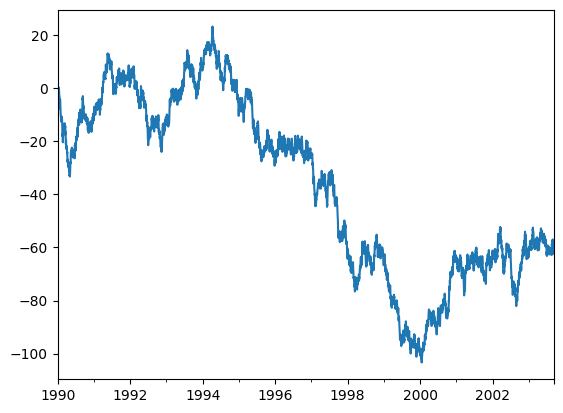

In [97]:
ts = pd.Series(np.random.randn(5000), index=pd.date_range("1/1/1990", periods=5000))

ts = ts.cumsum()

ts.plot();

In [98]:
plt.show();

<Figure size 640x480 with 0 Axes>

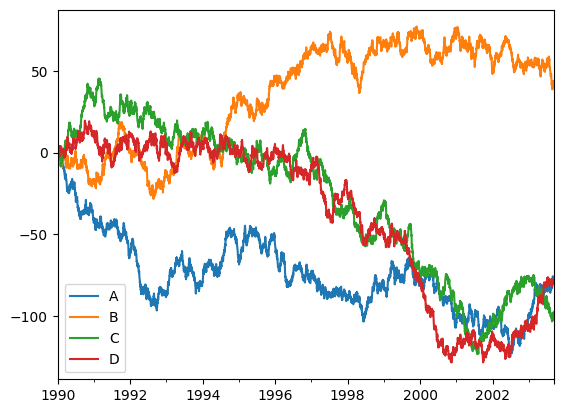

In [99]:
df = pd.DataFrame(
    np.random.randn(5000, 4), index=ts.index, columns=["A", "B", "C", "D"]
)

df = df.cumsum()

plt.figure();

df.plot();

plt.legend(loc='best');

##Importing and exporting data
**CSV**
Writing to a CSV file: using `DataFrame.to_csv()`:

In [100]:
df.to_csv("foo.csv")

Reading from a csv file: using `read_csv()`

In [101]:
pd.read_csv("foo.csv")

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.457733,-0.003350,0.216223,1.018152
1,1990-01-02,-0.371168,0.842269,1.756880,0.565213
2,1990-01-03,-1.350084,0.005459,0.669454,1.797903
3,1990-01-04,-1.556712,0.547125,0.587690,1.723087
4,1990-01-05,-1.680598,0.001926,-0.557148,1.774630
...,...,...,...,...,...
4995,2003-09-05,-76.893591,42.583555,-98.355076,-80.003453
4996,2003-09-06,-76.194841,43.650271,-98.474098,-78.452841
4997,2003-09-07,-79.057457,43.223045,-97.638585,-78.415665
4998,2003-09-08,-78.693090,41.869636,-98.929599,-78.889646


**HDF5**

Reading and writing to HDFStores.

Writing to a HDF5 Store using `DataFrame.to_hdf()`:

In [102]:
df.to_hdf("foo.h5", "df")

Reading to a HDF5 Store using `read_hdf():`:

In [103]:
pd.read_hdf("foo.h5", "df")

,A,B,C,D
1990-01-01,-0.457733,-0.003350,0.216223,1.018152
1990-01-02,-0.371168,0.842269,1.756880,0.565213
1990-01-03,-1.350084,0.005459,0.669454,1.797903
1990-01-04,-1.556712,0.547125,0.587690,1.723087
1990-01-05,-1.680598,0.001926,-0.557148,1.774630
...,...,...,...,...
2003-09-05,-76.893591,42.583555,-98.355076,-80.003453
2003-09-06,-76.194841,43.650271,-98.474098,-78.452841
2003-09-07,-79.057457,43.223045,-97.638585,-78.415665
2003-09-08,-78.693090,41.869636,-98.929599,-78.889646


##Excel

Reading & writing to Excel.

Writing to an excel file using `DataFrame.to_excel()`:

In [104]:
df.to_excel("foo.xlsx", sheet_name="Sheet1")

In [105]:
pd.read_excel("foo.xlsx", "Sheet1", index_col=None, na_values=["NA"])

,Unnamed: 0,A,B,C,D
0,1990-01-01,-0.457733,-0.003350,0.216223,1.018152
1,1990-01-02,-0.371168,0.842269,1.756880,0.565213
2,1990-01-03,-1.350084,0.005459,0.669454,1.797903
3,1990-01-04,-1.556712,0.547125,0.587690,1.723087
4,1990-01-05,-1.680598,0.001926,-0.557148,1.774630
...,...,...,...,...,...
4995,2003-09-05,-76.893591,42.583555,-98.355076,-80.003453
4996,2003-09-06,-76.194841,43.650271,-98.474098,-78.452841
4997,2003-09-07,-79.057457,43.223045,-97.638585,-78.415665
4998,2003-09-08,-78.693090,41.869636,-98.929599,-78.889646


##Series
a one-dimensional labeled array capable of holding any data type(integers, strings, ..etc)

`s = pd.Series(data, index=index)`


###**From ndarray**

If `data` is an ndarray, index must be the same length as data. If no index is passed, one will be created having values `[0, ..., len(data) - 1]`.

In [106]:
# From ndarray
s = pd.Series(np.random.randn(5), index=["a", "b", "c", "d", "e"])
s

a    1.976505
b    0.854902
c   -0.957706
d   -0.020031
e   -1.692973
dtype: float64

In [107]:
s.index

Index(['a', 'b', 'c', 'd', 'e'], dtype='object')

In [108]:
pd.Series(np.random.randn(5))

0    0.073194
1    0.852928
2    0.359001
3    1.057853
4    0.861047
dtype: float64

**From dict**
`Series` can be instantiated from dicts:

In [109]:
d = {"d":1, "a": 0, "c": 2}
pd.Series(d)

d    1
a    0
c    2
dtype: int64

In [110]:
# If an index is passed, the values in data corresponding to the labels in the index will be returned:

d = {"a": 0.0, "b": 1.0, "c": 2.0}

pd.Series(d)

a    0.0
b    1.0
c    2.0
dtype: float64

In [111]:
pd.Series(d, index=["b", "c", "d", "a"])

b    1.0
c    2.0
d    NaN
a    0.0
dtype: float64

**From scalar value**

If `data` is a scalar value, an index must be provided. The value will be repeated to match the length of the index.

In [112]:
pd.Series( '5a', index=["a", "b", "c", "d", "e"])

a    5a
b    5a
c    5a
d    5a
e    5a
dtype: object

In [113]:
s[s>s.median()]

a    1.976505
b    0.854902
dtype: float64

In [114]:

import openpyxl
import xlrd
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/Salient_cement_stats.xls")

,TABLE 1,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7
0,"SALIENT CEMENT STATISTICS1, 2",NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,(Thousand metric tons unless otherwise specified),NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,2014.0,2015.0,2016.0,2017.0,2018.0
5,United States:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Production:,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Cement3,NaN,NaN,82535.0,84405.0,84695.0,86356.0,86400.0
8,Clinker,NaN,NaN,74372.0,76043.0,75633.0,76678.0,77112.0
9,"Shipments from mills and terminals:3, 4",NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [115]:
def cfun(x):
    return int(x) if x else -1
    
pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release.xlsx", "Table1", usecols="A,B:G", converters={"MyInts": cfun})

,"Table 1. Value of Construction Put in Place in the United States, Seasonally Adjusted Annual Rate",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6
0,(Millions of dollars. Details may not add to t...,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
72,"lodging, religious, communication, and manufac...",NaN,NaN,NaN,NaN,NaN,NaN
73,NaN,NaN,NaN,NaN,NaN,NaN,NaN
74,"Data are at an annual rate, adjusted for seaso...",NaN,NaN,NaN,NaN,NaN,NaN
75,Table 3 provides estimated measures of samplin...,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
bb = pd.read_excel("/content/drive/MyDrive/Colab Notebooks/infra_data/release1.xlsx", "Sheet1", dtype={"MyInts": "Int64Dtype()", "MyText": str})
bb

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1


In [117]:
bb.dropna()

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Percent change\nJan 2023 from -,Unnamed: 8
0,Type of Construction\n,Jan\n2023p,Dec\n2022r,Nov\n2022r,Oct\n2022,Sep\n2022,Jan\n2022,Dec\n2022,Jan\n2022
2,Total Construction,1825653,1827535,1840294,1808343,1807497,1726585,-0.1,5.7
4,Residential,856912,861674,869322,874105,889018,890763,-0.6,-3.8
6,Nonresidential,968741,965861,970972,934238,918479,835822,0.3,15.9
7,Lodging,21930,21745,21774,21845,20144,15699,0.9,39.7
8,Office,96022,95315,95292,89874,87310,84401,0.7,13.8
9,Commercial,125503,129564,129822,125866,120099,102782,-3.1,22.1
10,Health care,55756,55646,55869,55157,52848,49593,0.2,12.4
11,Educational,104598,105281,105978,103429,98554,98413,-0.6,6.3
12,Religious,3057,2920,2837,2707,3047,2750,4.7,11.2


In [118]:
bb[bb.columns[:9]].dtypes

Unnamed: 0                         object
Unnamed: 1                         object
Unnamed: 2                         object
Unnamed: 3                         object
Unnamed: 4                         object
Unnamed: 5                         object
Unnamed: 6                         object
Percent change\nJan 2023 from -    object
Unnamed: 8                         object
dtype: object

In [119]:
import os
import warnings

warnings.filterwarnings("ignore")

os.chdir("../../..")

In [121]:
import torch
from torch import nn

class FullyConnectedModule(nn.Module):
  def __init__(self, input_size: int, output_size: int, hidden_size: int, n_hidden_layers: int):
    super().__init__()

    # input layer
    module_list = [nn.Linear(input_size, hidden_size), nn.ReLU()]
    # hidden layers
    for _ in range(n_hidden_layers):
        module_list.extend([nn.Linear(hidden_size, hidden_size), nn.ReLU()])
    # output layer
    module_list.append(nn.Linear(hidden_size, output_size))

    self.sequential = nn.Sequential(*module_list)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
      # x of shape: batch_size x n_timesteps_in
      # output of shape batch_size x n_timesteps_out
      return self.sequential(x)

# test that network works as intended
network = FullyConnectedModule(input_size=5, output_size=2, hidden_size=10, n_hidden_layers=2)
x = torch.rand(20, 5)
network(x).shape

torch.Size([20, 2])